In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
train_data = pd.read_csv("/content/gdrive/My Drive/dacon/train.csv").iloc[:, 1:].dropna(how = 'any')
train_data.index = range(len(train_data))
test_data = pd.read_csv("/content/gdrive/My Drive/dacon/test.csv").iloc[:, 1:]
submission = pd.read_csv("/content/gdrive/My Drive/dacon/sample_submission.csv")

In [4]:
train_data.shape, test_data.shape

((39992, 2), (5000, 1))

In [5]:
train_data.head()

,category,data
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [6]:
test_data.head()

,data
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 11년간 일하고 혈암과 백혈병 진단을 받은 ...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."


In [7]:
def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)
    return corpus

In [8]:
train_data.data = clean_text(train_data.data)
test_data.data = clean_text(test_data.data)

In [9]:
train_data_text = list(train_data['data'])

train_clear_text = []

for i in tqdm(range(len(train_data_text))):
  train_clear_text.append(str(train_data_text[i]).replace('\\n', ''))
train_data['clear_text'] = train_clear_text
train_data.head()

100%|██████████| 39992/39992 [00:00<00:00, 442592.58it/s]


,category,data,clear_text
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올...","빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 세,세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠시 딴일...","티비 세,세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠시 딴일..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...


In [10]:
train_clear_text = list(train_data['clear_text'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  train_clear_text2.append(temp)
train_data['clear_text'] = train_clear_text2
train_data.head()

,category,data,clear_text
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...,신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...,학교이름에 남자 도 붙여주세요 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올...",빙상연맹 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요 최근 동계올...
3,1,"티비 세,세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠시 딴일...",티비 세 세 관람가도 연령확인 의무화 하자 제기 에전에 티비를 보다가 잠시 딴일...
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...,무더운 여름철엔 남성들도 시원한 자율복장을 해야 무더운 여름철에는 남성들도 노넥타...


In [11]:
test_data_text = list(test_data['data'])

test_clear_text = []

for i in tqdm(range(len(test_data_text))):
  test_clear_text.append(test_data_text[i].replace('\\n', ' '))
test_data['clear_text'] = test_clear_text
test_data.head()

100%|██████████| 5000/5000 [00:00<00:00, 349263.39it/s]


,data,clear_text
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에 *지역 어린이...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 년간 일하고 혈암과 백혈병 진단을 받은 사람이...,국민위원에가 삼성편만들어요. 삼성에서 년간 일하고 혈암과 백혈병 진단을 받은 사람이...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부...","방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부..."


In [12]:
test_clear_text = list(test_data['clear_text'])

test_clear_text2 = []

for text in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》]', ' ', text)
  test_clear_text2.append(temp)
test_data['clear_text'] = test_clear_text2
test_data.head()

,data,clear_text
0,소년법 폐지해주세요. 법 아래에서 보호받아야 할 아이들이\n법으로 인해 보호받지 못...,소년법 폐지해주세요 법 아래에서 보호받아야 할 아이들이 법으로 인해 보호받지 못하...
1,국공립 유치원 증설에 관하여. 국공립 유치원 부지 학보와건립및 증설에\n*지역 어린...,국공립 유치원 증설에 관하여 국공립 유치원 부지 학보와건립및 증설에 지역 어린이...
2,나경원파면. 나경원의원의 동계올림픽 위원을 파면해 주세요,나경원파면 나경원의원의 동계올림픽 위원을 파면해 주세요
3,국민위원에가 삼성편만들어요. 삼성에서 년간 일하고 혈암과 백혈병 진단을 받은 사람이...,국민위원에가 삼성편만들어요 삼성에서 년간 일하고 혈암과 백혈병 진단을 받은 사람이...
4,"방과후,유치원,어린이집 영어교육을 유지시켜주세요. 저는 아이 셋 키우는 평범한 주부...",방과후 유치원 어린이집 영어교육을 유지시켜주세요 저는 아이 셋 키우는 평범한 주부...


In [13]:
stop_df = pd.read_csv('/content/gdrive/My Drive/dacon/한국어불용어100.txt', sep = '\t', header = None, names = ['형태','품사','비율'])
stop_df.tail()

,형태,품사,비율
95,원,NNB,0.000492
96,잘,MAG,0.000491
97,통하,VV,0.000487
98,소리,NNG,0.000486
99,놓,VX,0.000483


In [14]:
stop_df.loc[100] = '가'
stop_df.loc[101] = '합니다'

In [15]:
stop_words = list(stop_df.형태)

In [16]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4 MB 94.5 MB/s 
     |████████████████████████████████| 448 kB 64.0 MB/s 
     |████████████████████████████████| 86 kB 8.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ bash -x
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/

In [17]:
from konlpy.tag import Mecab
mecab = Mecab()

In [18]:
X_train = []

text = list(train_data['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_train.append(temp_X)

100%|██████████| 39992/39992 [01:01<00:00, 645.93it/s]


In [19]:
X_test = []

text = list(test_data['clear_text'])

for i in tqdm(range(len(text))):
  temp_X = []
  temp_X = mecab.nouns(text[i]) # 토큰화
  temp_X = [word for word in temp_X if not word in stop_words] # 불용어 제거
  temp_X = [word for word in temp_X if len(word) > 1]
  X_test.append(temp_X)

100%|██████████| 5000/5000 [00:12<00:00, 390.34it/s]


In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop

In [24]:
threshold = 11
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45158
등장 빈도가 10번 이하인 희귀 단어의 수: 32538
단어 집합에서 희귀 단어의 비율: 72.05367819655432
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2517719595441634


In [25]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 10 이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 12621


In [26]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
token_X_train = tokenizer.texts_to_sequences(X_train)
token_X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
y_train = to_categorical(np.array(train_data['category']))

In [28]:
drop_train = [index for index, sentence in enumerate(token_X_train) if len(sentence) < 1]

In [29]:
# 빈 샘플들을 제거
del_X_train = np.delete(token_X_train, drop_train, axis=0)
del_y_train = np.delete(y_train, drop_train, axis=0)
print(len(del_X_train))
print(len(del_y_train))

39966
39966


train data의 최대 길이 : 5661
train data의 평균 길이 : 66.62032727818647


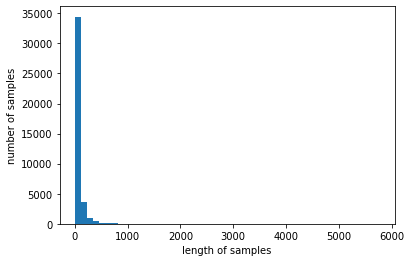

In [30]:
print('train data의 최대 길이 :',max(len(l) for l in del_X_train))
print('train data의 평균 길이 :',sum(map(len, del_X_train))/len(del_X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :  3806
test data의 평균 길이 :  66.1876


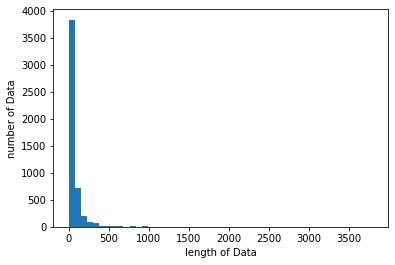

In [31]:
print("test data의 최대 길이 : ", max(len(l) for l in token_X_test))
print("test data의 평균 길이 : ", sum(map(len, token_X_test))/ len(token_X_test))
plt.hist([len(s) for s in token_X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [33]:
max_len = 300
below_threshold_len(max_len, del_X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 97.22263924335685


In [34]:
pad_X_train = pad_sequences(del_X_train, padding='post', maxlen = max_len)
pad_X_test = pad_sequences(token_X_test, padding='post', maxlen = max_len)

In [39]:
word_index = tokenizer.word_index

In [40]:
print(pad_X_train.shape, pad_X_test.shape)

(39966, 300) (5000, 300)


In [43]:
#파라미터 설정
embedding_dim = 200  
padding_type='post'

# simple RNN

In [45]:
# Simple RNN 레이어를 사용한 모델 (model1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_len),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(3, activation='softmax')
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          2524200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 300, 64)           16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 300, 64)           8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2,557,867
Trainable params: 2,557,867
Non-trainable params: 0
_________________________________________________________________


In [60]:
# 모델 실행해보기
history = model1.fit(pad_X_train, del_y_train, epochs=10, batch_size=100, validation_split= 0.2)

Epoch 1/10
320/320 [==============================] - 296s 920ms/step - loss: 1.0988 - accuracy: 0.3623 - val_loss: 1.0995 - val_accuracy: 0.3616
Epoch 2/10
320/320 [==============================] - 247s 772ms/step - loss: 1.0983 - accuracy: 0.3538 - val_loss: 1.0951 - val_accuracy: 0.3704
Epoch 3/10
320/320 [==============================] - 246s 769ms/step - loss: 1.0974 - accuracy: 0.3513 - val_loss: 1.0985 - val_accuracy: 0.3540
Epoch 4/10
320/320 [==============================] - 245s 766ms/step - loss: 1.0959 - accuracy: 0.3530 - val_loss: 1.0982 - val_accuracy: 0.3353
Epoch 5/10
320/320 [==============================] - 246s 768ms/step - loss: 1.0939 - accuracy: 0.3474 - val_loss: 1.0993 - val_accuracy: 0.3544
Epoch 6/10
320/320 [==============================] - 246s 767ms/step - loss: 1.0894 - accuracy: 0.3488 - val_loss: 1.0998 - val_accuracy: 0.3344
Epoch 7/10
320/320 [==============================] - 247s 771ms/step - loss: 1.0860 - accuracy: 0.3497 - val_loss: 1.1069 -

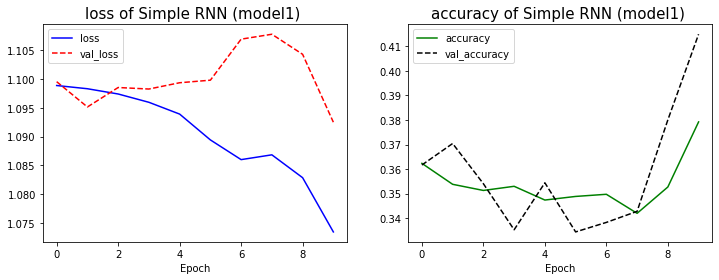

In [61]:
# Simple RNN 모델 (model1) 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show;

# 단방향 LSTM

In [62]:
# 단방향 LSTM 레이어를 사용한 모델 (model2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_len),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(3, activation='softmax')
    ])
    
model2.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy']) 
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 200)          2524200   
                                                                 
 lstm_6 (LSTM)               (None, 300, 64)           67840     
                                                                 
 lstm_7 (LSTM)               (None, 300, 64)           33024     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,658,283
Trainable params: 2,658,283
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model2.fit(pad_X_train, del_y_train, epochs=50, batch_size=100, validation_split= 0.2)

Epoch 1/50
320/320 [==============================] - 18s 56ms/step - loss: 0.8882 - accuracy: 0.5202 - val_loss: 0.8870 - val_accuracy: 0.5193
Epoch 2/50
320/320 [==============================] - 17s 52ms/step - loss: 0.8045 - accuracy: 0.5642 - val_loss: 0.8090 - val_accuracy: 0.5665
Epoch 3/50
320/320 [==============================] - 17s 52ms/step - loss: 0.7766 - accuracy: 0.6872 - val_loss: 0.7603 - val_accuracy: 0.7315
Epoch 4/50
320/320 [==============================] - 17s 52ms/step - loss: 0.6262 - accuracy: 0.7744 - val_loss: 0.5981 - val_accuracy: 0.8157
Epoch 5/50
320/320 [==============================] - 16s 51ms/step - loss: 0.5819 - accuracy: 0.7893 - val_loss: 0.5858 - val_accuracy: 0.7541
Epoch 6/50
320/320 [==============================] - 17s 52ms/step - loss: 0.4497 - accuracy: 0.8468 - val_loss: 0.5585 - val_accuracy: 0.8176
Epoch 7/50
320/320 [==============================] - 17s 52ms/step - loss: 0.4422 - accuracy: 0.8559 - val_loss: 0.4364 - val_accuracy:

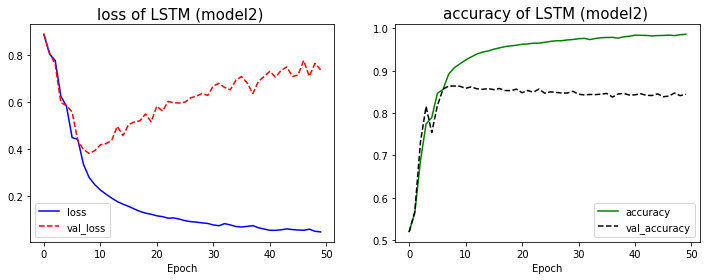

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show;

# 양방향 LSTM

In [65]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_len),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(3, activation='softmax')
    ])
    
model3.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics = ['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 200)          2524200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 128)         135680    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 300, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                      

In [66]:
history = model3.fit(pad_X_train, del_y_train, epochs=50, batch_size=100, validation_split= 0.2)

Epoch 1/50
320/320 [==============================] - 47s 122ms/step - loss: 0.4395 - accuracy: 0.8233 - val_loss: 0.3396 - val_accuracy: 0.8735
Epoch 2/50
320/320 [==============================] - 37s 115ms/step - loss: 0.2721 - accuracy: 0.8984 - val_loss: 0.3507 - val_accuracy: 0.8703
Epoch 3/50
320/320 [==============================] - 37s 116ms/step - loss: 0.2151 - accuracy: 0.9179 - val_loss: 0.3655 - val_accuracy: 0.8685
Epoch 4/50
320/320 [==============================] - 37s 116ms/step - loss: 0.1748 - accuracy: 0.9324 - val_loss: 0.4149 - val_accuracy: 0.8643
Epoch 5/50
320/320 [==============================] - 37s 115ms/step - loss: 0.1482 - accuracy: 0.9428 - val_loss: 0.4531 - val_accuracy: 0.8578
Epoch 6/50
320/320 [==============================] - 37s 115ms/step - loss: 0.1344 - accuracy: 0.9484 - val_loss: 0.5016 - val_accuracy: 0.8505
Epoch 7/50
320/320 [==============================] - 37s 116ms/step - loss: 0.1167 - accuracy: 0.9540 - val_loss: 0.5200 - val_ac

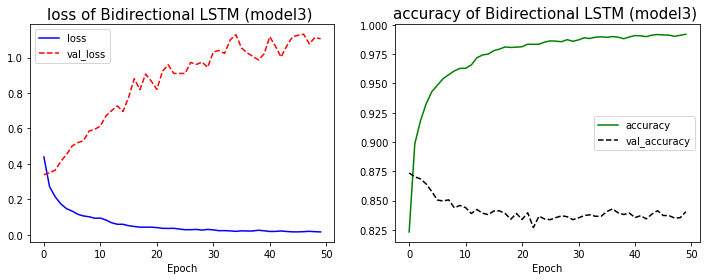

In [67]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show;

# StratifiedKFold 적용 - model 2

In [70]:
y_train = np.array([x for x in train_data['category']])
del_y_train = np.delete(y_train, drop_train, axis=0)

In [72]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
y_test1 = np.zeros((pad_X_test.shape[0], 3))

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, del_y_train), 1):
    print(f'training model for CV #{i}')

    model2.fit(pad_X_train[i_trn],
            to_categorical(del_y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(del_y_train[i_val])),
            epochs=10,
            batch_size=512)
    
    y_test1 += model2.predict(pad_X_test) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
63/63 [==============================] - 7s 107ms/step - loss: 0.1619 - accuracy: 0.9594 - val_loss: 0.1473 - val_accuracy: 0.9595
Epoch 2/10
63/63 [==============================] - 7s 108ms/step - loss: 0.1217 - accuracy: 0.9696 - val_loss: 0.1466 - val_accuracy: 0.9595
Epoch 3/10
63/63 [==============================] - 7s 107ms/step - loss: 0.1068 - accuracy: 0.9735 - val_loss: 0.1490 - val_accuracy: 0.9592
Epoch 4/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0968 - accuracy: 0.9760 - val_loss: 0.1507 - val_accuracy: 0.9593
Epoch 5/10
63/63 [==============================] - 7s 110ms/step - loss: 0.0898 - accuracy: 0.9785 - val_loss: 0.1538 - val_accuracy: 0.9593
Epoch 6/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0853 - accuracy: 0.9800 - val_loss: 0.1576 - val_accuracy: 0.9588
Epoch 7/10
63/63 [==============================] - 7s 109ms/step - loss: 0.0813 - accuracy: 0.9808 - val_loss: 0.1597 - va

# 테스트 데이터 적용 - model 2

In [73]:
y_test1

array([[9.87452671e-01, 2.74094196e-03, 9.80642182e-03],
       [2.99075985e-03, 4.39289099e-04, 9.96569946e-01],
       [3.20217892e-03, 9.95782837e-01, 1.01497817e-03],
       ...,
       [2.19594707e-03, 9.97037187e-01, 7.66853091e-04],
       [9.88649726e-01, 7.55984537e-03, 3.79041710e-03],
       [9.56923530e-01, 3.37309718e-03, 3.97033750e-02]])

In [74]:
topic = []
for i in range(len(y_test1)):
    topic.append(np.argmax(y_test1[i]))

In [75]:
submission

,index,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [76]:
# sample_submission 에 대입
submission['category'] = topic
submission

,index,category
0,0,0
1,1,2
2,2,1
3,3,0
4,4,2
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,0


In [77]:
submission.to_csv('/content/gdrive/My Drive/dacon/submission_v7.csv',index = False)

# 조기 종료 옵션 추가 - model 2

In [78]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
y_test2 = np.zeros((pad_X_test.shape[0], 3))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, del_y_train), 1):
    print(f'training model for CV #{i}')

    model2.fit(pad_X_train[i_trn],
            to_categorical(del_y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(del_y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    y_test2 += model2.predict(pad_X_test) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
63/63 [==============================] - 7s 111ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.0386 - val_accuracy: 0.9856
Epoch 2/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0346 - accuracy: 0.9882 - val_loss: 0.0360 - val_accuracy: 0.9885
Epoch 3/10
63/63 [==============================] - 7s 106ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.0401 - val_accuracy: 0.9871
Epoch 4/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.0389 - val_accuracy: 0.9869
Epoch 5/10
63/63 [==============================] - 7s 107ms/step - loss: 0.0289 - accuracy: 0.9898 - val_loss: 0.0544 - val_accuracy: 0.9820
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
63/63 [==============================] - 7s 108ms/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.0282 - val_accuracy: 0.9895
Epoch 2/10
63/63 [==============================] - 7s 108ms/step - lo

# 테스트 데이터 적용 - model 2

In [79]:
y_test2

array([[9.97140884e-01, 1.18688565e-03, 1.67217363e-03],
       [1.47406696e-03, 1.15557057e-04, 9.98410404e-01],
       [5.90694719e-04, 9.99260783e-01, 1.48492343e-04],
       ...,
       [5.72323306e-05, 9.99918967e-01, 2.37866152e-05],
       [9.98523518e-01, 3.54630298e-04, 1.12182132e-03],
       [9.74913478e-01, 9.59083045e-04, 2.41274932e-02]])

In [80]:
topic = []
for i in range(len(y_test2)):
    topic.append(np.argmax(y_test2[i]))

In [81]:
# sample_submission 에 대입
submission['category'] = topic
submission

,index,category
0,0,0
1,1,2
2,2,1
3,3,0
4,4,2
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,0


In [82]:
submission.to_csv('/content/gdrive/My Drive/dacon/submission_v8.csv',index = False)

# StratifiedKFold 적용 - model 3

In [83]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
y_test3 = np.zeros((pad_X_test.shape[0], 3))

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, del_y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(pad_X_train[i_trn],
            to_categorical(del_y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(del_y_train[i_val])),
            epochs=10,
            batch_size=512)
    
    y_test3 += model3.predict(pad_X_test) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
63/63 [==============================] - 16s 249ms/step - loss: 0.1534 - accuracy: 0.9632 - val_loss: 0.1320 - val_accuracy: 0.9618
Epoch 2/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0899 - accuracy: 0.9762 - val_loss: 0.1360 - val_accuracy: 0.9606
Epoch 3/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0711 - accuracy: 0.9807 - val_loss: 0.1399 - val_accuracy: 0.9601
Epoch 4/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0587 - accuracy: 0.9834 - val_loss: 0.1440 - val_accuracy: 0.9600
Epoch 5/10
63/63 [==============================] - 16s 248ms/step - loss: 0.0498 - accuracy: 0.9853 - val_loss: 0.1497 - val_accuracy: 0.9583
Epoch 6/10
63/63 [==============================] - 16s 248ms/step - loss: 0.0431 - accuracy: 0.9869 - val_loss: 0.1564 - val_accuracy: 0.9590
Epoch 7/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.16

# 테스트 데이터 적용 - model 3

In [84]:
y_test3

array([[2.91099743e-03, 2.51031315e-04, 9.96837944e-01],
       [5.08916895e-05, 4.68513095e-06, 9.99944448e-01],
       [1.98076557e-03, 9.97923672e-01, 9.55573720e-05],
       ...,
       [5.21990173e-04, 9.99424025e-01, 5.40010640e-05],
       [9.99715552e-01, 6.07382188e-05, 2.23704450e-04],
       [6.68386344e-04, 5.89142653e-05, 9.99272704e-01]])

In [85]:
topic = []
for i in range(len(y_test3)):
    topic.append(np.argmax(y_test3[i]))

In [86]:
# sample_submission 에 대입
submission['category'] = topic
submission

,index,category
0,0,2
1,1,2
2,2,1
3,3,0
4,4,2
...,...,...
4995,4995,2
4996,4996,1
4997,4997,1
4998,4998,0


In [87]:
submission.to_csv('/content/gdrive/My Drive/dacon/submission_v9.csv',index = False)

# 조기 종료 옵션 추가 - model 3

In [88]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
y_test4 = np.zeros((pad_X_test.shape[0], 3))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, del_y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(pad_X_train[i_trn],
            to_categorical(del_y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(del_y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    y_test4 += model3.predict(pad_X_test) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
63/63 [==============================] - 16s 248ms/step - loss: 0.0141 - accuracy: 0.9936 - val_loss: 0.0148 - val_accuracy: 0.9930
Epoch 2/10
63/63 [==============================] - 15s 246ms/step - loss: 0.0192 - accuracy: 0.9919 - val_loss: 0.0201 - val_accuracy: 0.9909
Epoch 3/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0165 - accuracy: 0.9930 - val_loss: 0.0224 - val_accuracy: 0.9895
Epoch 4/10
63/63 [==============================] - 16s 248ms/step - loss: 0.0139 - accuracy: 0.9937 - val_loss: 0.0251 - val_accuracy: 0.9892
Epoch 00004: early stopping
training model for CV #2
Epoch 1/10
63/63 [==============================] - 16s 247ms/step - loss: 0.0140 - accuracy: 0.9937 - val_loss: 0.0130 - val_accuracy: 0.9941
Epoch 2/10
63/63 [==============================] - 15s 246ms/step - loss: 0.0125 - accuracy: 0.9940 - val_loss: 0.0159 - val_accuracy: 0.9931
Epoch 3/10
63/63 [==============================] - 16s 247ms/st

# 테스트 데이터 적용 - model 3

In [89]:
y_test4

array([[1.12229727e-04, 6.52579115e-06, 9.99881223e-01],
       [6.03089353e-06, 2.34967601e-07, 9.99993727e-01],
       [7.04071226e-05, 9.99927610e-01, 1.98610519e-06],
       ...,
       [1.61345839e-05, 9.99979898e-01, 3.94385458e-06],
       [9.99990404e-01, 3.27446537e-06, 6.36279640e-06],
       [1.78926199e-02, 2.01683066e-03, 9.80090544e-01]])

In [90]:
topic = []
for i in range(len(y_test4)):
    topic.append(np.argmax(y_test4[i]))

In [91]:
# sample_submission 에 대입
submission['category'] = topic
submission

,index,category
0,0,2
1,1,2
2,2,1
3,3,0
4,4,2
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,0


In [92]:
submission.to_csv('/content/gdrive/My Drive/dacon/submission_v10.csv',index = False)